# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [6]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

sys.path.append('../')
import functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [8]:
def Pease_Model_v2(event_df, wf=0.02, ta=35, poly_dir=145, Hi = 25 * units('cm'), show_plot = False):


    def convert_to_k(T):

        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T


    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    def open_Qld(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_strd_{event_year}_v7.nc') as ds_sw:
            down_longwave = ds_sw.strd.sel(time=event_df.time.values).values * units('W/m2')

        qld = (down_longwave) # longwave down

        return qld
    
    
    def open_Qr(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds_sw:
            down_shortwave = ds_sw.ssrd.sel(time=event_df.time.values).values * units('W/m2')

        qr = (1-0.1)*(down_shortwave) # short wave radiation absorbed (10% albedo)

        return qr
    
    
    
    # wind component that extends polynya
#     wind_angle = (poly_dir+ta)*units('degree')
#     wind_comp = vectors.comp_along_theta(event_df['u10'].values, event_df['v10'].values, wind_angle)
#     wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')


    
    # observed wind speed and direction
    wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')
    wind_dir = vectors.vector_angle(event_df['u10'].values, event_df['v10'].values)
    
    # predicted ice speed and direction
    ice_speed = wf * wind_speed.to('km/day')
    ice_dir = wind_dir - (ta*units('degree'))
    
    # back to components
    ice_u = ice_speed * np.cos(ice_dir.to('radian').magnitude)
    ice_v = ice_speed * np.sin(ice_dir.to('radian').magnitude)
    
    # component of ice drift along polynya direction
    ice_comp_along_polynya = vectors.comp_along_theta(ice_u, ice_v, poly_dir*units('degree'))
    Vi = ice_comp_along_polynya
    
    # daily ice drift
#     Vi = wf * wind_comp*units('m/s').to('km/day')

    # air temperature
    Ta = event_df['t2m'].values * units('degC')

    # water temperature
    Tw = -1.8 * units('degC')

    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
#     Qld = -open_Qld(event_df)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr(event_df) # short wave radiation absorbed (5% albedo)

    Qnet = Qlu+Qld+Qs+Qr

    # heat flux to ice production rate
    #-----------------------------------
    Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(Qs, label='sensible')
        ax.axhline(Qlu, label='lw u', c='b')
        ax.plot(Qld, label='lw d')
        ax.plot(Qr, label='shortwave')
        ax.plot(Qnet, c='k', label='net')
        ax.legend()
        
        
        
    # iteratively solve for the length
    #---------------------------------
    Xp = np.array([0]) * units('m')

    for tt in range(len(event_df)):

        # current length
        X_curr = Xp[-1]

        # change in length
        dXdt = Vi[tt] - X_curr * Fi[tt] / Hi
        dX = dXdt * units('day')


        Xnew = X_curr + dX
        Xp = np.append(Xp, Xnew)


    X_num = Xp[1:].to('km')

    # solve for limiting width
    #---------------------------------
    X_max = (Vi * Hi / Fi).to('km')
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(event_df.time, np.cumsum(Vi.magnitude), marker='.', c='k', label='Fi=0')
        ax.plot(event_df.time, X_num.to('km'), label='iter')
        ax.plot(event_df.time, X_max.to('km'), label='limiting width')
        ax.bar(event_df.time, event_df.length_145max, color='lightgray', label='obs')
        plt.legend()

    X_zip = np.cumsum(Vi*units('day'))
    
    return X_num, X_max, t95, X_zip, Ta, Vi, wind_speed, event_df['u10'].values, Fi

## Reference grids

In [9]:
# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))



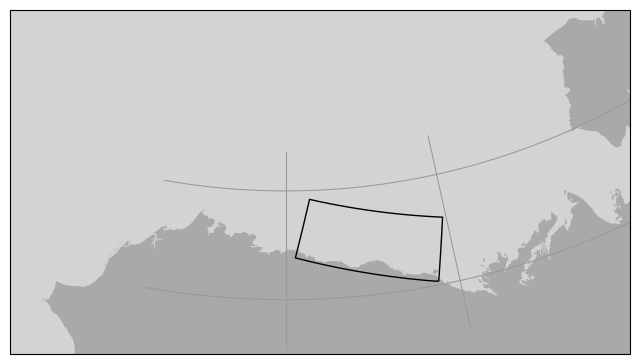

In [10]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())



line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69.25,72]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-150,-137.5]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


In [11]:
df = pd.read_csv('../data/compiled_stats.csv')



df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')

df['si_km'] = df['si'] * units('cm/s').to('km/day')

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    
    angles = 90-df[f'{cat}']
    angles[angles<0]+=360
    df[f'{cat}_r'] = angles
    
df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude

In [12]:
df['cum_drift'] = 0
df['X_Pease'] = 0
seqs = np.array(list(set(df.sequence[df.sequence!=-999])))

for ss in seqs:
    df.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(df.loc[df.sequence == ss, 'ese10']).values
    
    
for IND in np.where(df.year >= 2003)[0]:
    # model params
    #===============================
    wf = 0.02 # wind factor
    ta = 20   # CW turning angle wind to ice, degrees
    poly_dir = 145  #  polynya direction, degrees CCW from E
    Hi = 15 * units('cm')
    #===============================

#     for IND in np.where(df.sequence == ss)[0]:
    out = Pease_Model_v2(df.iloc[IND:IND+1], wf=wf, ta=ta, poly_dir=poly_dir, Hi = Hi, show_plot = False)
    X_num, X_max, t95, X_zip, Ta, Vi, wind_speed, east_wind, Fi = out
    df.loc[IND, 'X_Pease'] = X_max
        

# identify base period
dfb = df[df['2003_2023']]
dfr = df[df.year >= 2003]

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_9215/3230432937.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-10.77371356]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.sequence == ss, 'cum_drift'] = np.cumsum(df.loc[df.sequence == ss, 'ese10']).values
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_9215/3230432937.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-45.0209142233977 kilometer' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[IND, 'X_Pease'] = X_max


In [16]:
for month in [12,1,2,3,4]:
    
    cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
    cond = cond & (dfr['month']==month)
    
    print(dfr['time'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    print(dfr['sequence'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    

4851    2019-12-12
Name: time, dtype: object
4851    116
Name: sequence, dtype: int64
5489    2024-01-14
Name: time, dtype: object
5489    147
Name: sequence, dtype: int64
5232    2022-02-28
Name: time, dtype: object
5232    132
Name: sequence, dtype: int64
5697    2025-03-11
Name: time, dtype: object
5697    157
Name: sequence, dtype: int64
4368    2016-04-12
Name: time, dtype: object
4368    85
Name: sequence, dtype: int64


In [17]:
cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
all_ss = list(set(dfr['sequence'][cond]))


# cond = ((dfr['sequence']!=-999))
# all_ss = list(set(dfr['sequence'][cond]))


In [18]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
#         dir_cond = (dff['a10_r'] > 255) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 6)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10)
    return speed_cond

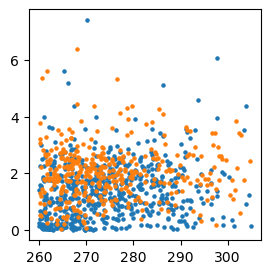

In [19]:
late_df = df[df.year >= 2016]
earl_df = df[(df.year >= 2003)&(df.year < 2016)]

fig, ax= plt.subplots(figsize=(3,3))

cond =  (earl_df.s10 > 3) &dir_conds(earl_df, 'wind') 
# plt.hist(earl_df[cond]['a10_r'], bins=np.arange(255,310,2), alpha=0.5, density=True)

plt.scatter(earl_df[cond]['a10_r'], earl_df[cond]['si']/earl_df[cond]['s10'], s=5)


cond = (late_df.s10 > 3) &dir_conds(late_df, 'wind') 
# plt.hist(late_df[cond]['a10_r'], bins=np.arange(255,310,2), alpha=0.5, density=True)
plt.scatter(late_df[cond]['a10_r'], late_df[cond]['si']/late_df[cond]['s10'], s=5)

In [220]:
0.017 * 6 * units('m/s').to('km/day')

<Quantity(8.8128, 'kilometer / day')>

### Define direction ranges

In [13]:
# wind_dir_cond = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# ice_dir_cond = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)
# wind_speed_cond = DF['s10'] > 7


# dir_conds = {}
# dir_conds['wind'] = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# dir_conds['ice'] = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)

# dir_conds = {}
# dir_conds['wind'] = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# dir_conds['ice'] = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)


def dir_conds(dff, cat):
    
    if cat == 'wind':
        
#         dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
#         dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 300)
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
#         dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)

    elif cat == 'poly':
        
        dir_cond = (dff['centermass_direction_r'] > 280) & (dff['centermass_direction_r'] < 330)
        
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 6)

#         speed_cond = np.copy(dff['s10'] > 8.5)
#         speed_cond[dff.year>=2016] = np.copy(dff['s10'][dff.year>=2016] > 6)

#         speed_cond = np.copy(dff['s10'] > 7.5)
#         speed_cond[dff.year>=2016] = np.copy(dff['s10'][dff.year>=2016] > 5.5)
        
#         years = np.arange(2003,2026)
#         ws_thresh = np.linspace(9,5.5, len(years))
#         speed_cond = np.copy(dff['s10'] > 10)
#         for year in years:
#             speed_cond[dff.year==year] = (dff['s10'][dff.year==year] > ws_thresh[years==year][0])


    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10)

    return speed_cond

speed_bins = {}
speed_bins['wind'] = np.arange(0,17,1)
speed_bins['ice'] = np.arange(0,35,2)



In [ ]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

In [ ]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

In [14]:
def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    

### Specify conditions

In [64]:
#=============
L = 9
#=============


#=============
DF = dfr
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

# shoulder = (DF['season_start_flag'] + DF['season_end_flag'])

shoulder = DF['season_start_flag']

# shoulder = DF.year<0

comp_ = (DF.extent==0)
comp_[(DF.day_before_event>=-3)]=False
comp_[(DF.day_after_event<=2)&(DF.day_after_event>-999)]=False

days_before = np.array([-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>=1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
# conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
# conds_during = [(DF['event_day'] == dd) for dd in days_during]
conds_during = [((DF['event_day'] == dd)&(shoulder==False)) for dd in days_during]
# conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
# conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]
conds_more = [((DF['event_day'] > L))&(shoulder==False)]


# day_final = np.array([L+2])
# labels_final = np.array(['$t_{f}$'])
# conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>=1) for dd in days_after]   


# x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
# x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
# all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))


x_values = np.concatenate((1+days_before, days_during, days_more, 1+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_after))


across = {}
for dd, cond in zip(x_labels, all_cond):

    across[dd] = {}
    across[dd]['date'] = DF.time[cond].values


13
150


In [65]:
x_labels

array(['$t_{i}$\n-2', '$t_{i}$\n-1', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10+', '$t_{f}$\n+1', '$t_{f}$\n+2'], dtype='<U10')

<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_9215/995883945.py:79: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_9215/995883945.py:100: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nlength\n($\\times\mathrm{km}$)', rotation=0, labelpad=25, va='center')


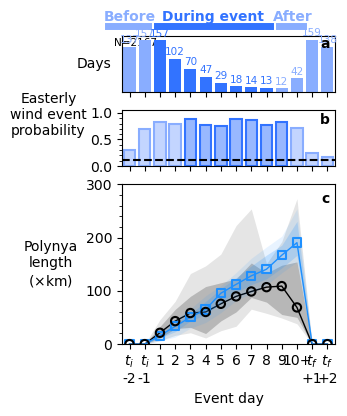

In [70]:
fig, axs = plt.subplots(3,1,figsize=(2.75,4), gridspec_kw={'height_ratios':[0.35,0.35,1]})


    
color1 = [50/255,115/255, 255/255]   
color2 = [137/255,173/255, 255/255]   
    
    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
for dd, cond in zip(x_values, all_cond):
    
    if (dd >0)&(dd < 9):
        ax.bar(dd, np.sum(cond), color=color1)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color1, va='bottom', ha='center', size=7.5)
    else:
        ax.bar(dd, np.sum(cond), color=color2)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color2, va='bottom', ha='center', size=7.5)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='k', size = 7.5,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-1.75+1.25, x_values.max()+1.75-1.25)
    ax.set_xticks(x_values)
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels);
# plt.xticks(fontsize=9)



for ax in axs[1:2]:
    ax.set_ylim(0,1.05)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


axs[1].set_ylabel('Easterly\nwind event\nprobability', rotation=0, labelpad=30)
# axs[3].set_ylabel('Alongshore\nice drift\nprobability', rotation=0, labelpad=30)

ax = axs[1]

for ax, cat in zip(axs[1:2], ['wind', 'ice']):
    
    wind_prob = np.array([])
    for dd, cond in zip(x_values, all_cond):
        cond1 = cond & (dir_conds(DF, cat))#& speed_conds(DF, cat)
        wind_prob = np.append(wind_prob, np.sum(cond1)/np.sum(cond))
        
    width = 0.75    
        
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,color = color1, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    
    
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,facecolor='None', edgecolor = color1, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    
#     ax.plot(x_values, wind_prob, color = 'k', ls='solid', marker='s', alpha=1, zorder=1)

cond = comp_
cond1 = cond & (dir_conds(DF, cat)&speed_conds(DF, cat))
ax.axhline(np.sum(cond1)/np.sum(cond), ls='dashed', lw=1.5,  c = 'k', zorder=2)



ax = axs[2]
ax.set_ylim(0,300)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))


ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')
VAR = 'cum_drift'


pred_pers = {}
percents = [10,25,50,75,90]
for per in percents:
    pred_pers[per] = np.array([])

for dd, cond in zip(x_values, all_cond):
    for per in percents:
        pred_pers[per] = np.append(pred_pers[per], np.nanpercentile(DF[VAR][cond], per))
    
color = 'dodgerblue'
ax.plot(x_values, pred_pers[50], lw=1, c=color, zorder=-3)
ax.scatter(x_values, pred_pers[50], lw=1.5, edgecolor=color, marker='s', facecolor='None', zorder=1)
ax.fill_between(x_values, pred_pers[10], pred_pers[90], alpha=0.1, color=color, lw=0, zorder=-3)
ax.fill_between(x_values, pred_pers[25], pred_pers[75], alpha=0.2, color=color, lw=0 ,zorder=-3)

    
ax = axs[2]
ax.set_ylabel('Polynya\nlength\n($\\times\mathrm{km}$)', rotation=0, labelpad=25, va='center')
VAR = 'length_145max'

obs_pers = {}
percents = [10,25,50,75,90]
for per in percents:
    obs_pers[per] = np.array([])
    
for dd, cond in zip(x_values, all_cond):
    
    for per in percents:
        obs_pers[per] = np.append(obs_pers[per], np.nanpercentile(DF[VAR][cond], per))

color = 'k'
ax.plot(x_values, obs_pers[50], lw=1, c=color, zorder=-4)
ax.scatter(x_values, obs_pers[50], lw=1.5, edgecolor=color, marker='o', facecolor='None', zorder=1)
ax.fill_between(x_values, obs_pers[10], obs_pers[90], alpha=0.1, color=color, lw=0, zorder=-4)
ax.fill_between(x_values, obs_pers[25], obs_pers[75], alpha=0.2, color=color, lw=0 ,zorder=-4)



# VAR = 'X_Pease'
# lat_pers = {}
# percents = [10,25,50,75,90]
# for per in percents:
#     lat_pers[per] = np.array([])
    
# for dd, cond in zip(x_values, all_cond):
    
#     for per in percents:
#         lat_pers[per] = np.append(lat_pers[per], np.nanpercentile(DF[VAR][cond], per))

# color = 'darkorange'
# ax.plot(x_values[3:-2], lat_pers[50][3:-2], lw=1, c=color, zorder=-5)
# ax.scatter(x_values[3:-2], lat_pers[50][3:-2], lw=1.5, edgecolor='None', marker='d', facecolor=color, zorder=-1)
# ax.fill_between(x_values[3:-2], lat_pers[10][3:-2], lat_pers[90][3:-2], alpha=0.1, color=color, lw=0, zorder=-5)
# ax.fill_between(x_values[3:-2], lat_pers[25][3:-2], lat_pers[75][3:-2], alpha=0.2, color=color, lw=0 ,zorder=-5)




    
    
# Get the y-axis tick labels
xtick_labels = axs[-1].get_xticklabels()

# Change the color of specific y-axis tick labels
# for i, label in enumerate(xtick_labels):
#     if (i >=3)&(i<11):  # Change every other y-axis label to green
#         label.set_color(color1)
#     else:
#         label.set_color(color2)

        
ax = axs[0]

yy = 200
ax.plot([0.8,8.2], [yy,yy], c=color1, lw=5, clip_on=False)
ax.text(4.5,yy+7, 'During event', weight='bold', c=color1, va='bottom', ha='center', clip_on=False)
ax.plot([-2.4,0.2], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(-1,yy+7, 'Before', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
ax.plot([8.8,10.4], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(9.75,yy+7, 'After', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)


    
axs[-1].set_xlabel('Event day')

for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
    
# ax.plot(x_values[2:-4], np.linspace(0,200,len(x_values[2:-4])))
# fig.savefig('../figures/results/comp_time_v2.png', dpi=400, bbox_inches='tight')

In [67]:
long_events = list(set(dfr.sequence[(shoulder==False)&(dfr.event_length >= 10)]))

for ss in long_events:
    
    print(dfr.time[dfr.sequence==ss].values[0])


2007-04-19
2025-03-06
2017-12-09
2003-12-11
2022-12-24
2016-02-08
2016-02-26
2019-12-08
2016-04-05
2016-04-19
2024-01-03
2013-12-30


In [69]:
begin_season_events = list(set(dfr.sequence[(shoulder==True)]))

for ss in begin_season_events:
    
    print(dfr.time[dfr.sequence==ss].values[0],dfr.time[dfr.sequence==ss].values[-1] )

2002-12-01 2002-12-01
2007-12-01 2007-12-12
2004-12-01 2004-12-05
2006-12-01 2006-12-01
2020-12-01 2020-12-02


In [176]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'esei', 'ese10', 'si_km', 'a10_r', 'ai_r', 'centermass_direction_r',
       'max_length_direction_r', 'up', 'vp', 'ta_wi', 'ta_ip', 'ta_wp',
       'cum_drift', 'X_Pease'],
      dtype='object')

In [71]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'
# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)


In [72]:

open_thresh=10

map_sic = {}

for key in across.keys():

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(across[key]['date']), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


$t_{i}$
-2
$t_{i}$
-1
1
2
3
4
5
6
7
8
9
10+
$t_{f}$
+1
$t_{f}$
+2


1
3
5
8+


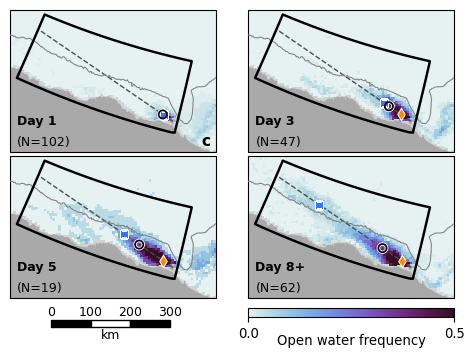

In [213]:
fig, axs = fn.makemap(view='wider_zoom3', contours = [-100], 
                      panels=(2,2), figsize=(6,3.75))
plt.subplots_adjust(hspace=0.025, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10
# iced = np.array([50.82842169,  68.58080734,  90.47338417,
#         98.24958483, 120.57204264, 128.47181612])
wind = pred_pers[50]
latt = lat_pers[50]
obss = obs_pers[50]


bearing = -55

FS = 10

# wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
# latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
# obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
# for key, n in zip([f'{m}' for m in [1,3,5,7,9]]+[f'10+'],
#                      range(6)):

for key, n in zip([f'{m}' for m in [1,3,5]]+['8+'],
                     range(4)):
    
    print(key)

#     axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
#                 ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(across[key]['date'])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

#     mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], 100*poly_maps[key]/total_maps[key], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
    
#     mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#           vmin=0, vmax=0.5, levels = np.arange(0,0.5,0.05), extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.6, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5, 0.75], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    
    # dashed line
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    
    
    for group, fc, ec, marker, ms, lw in zip([latt, wind, obss], 
                                       [ color, color1, 'None'], 
                                       [ 'white', 'white', 'k'], 
                                       ['d','s', 'o'], [40, 30, 35], [0.75,0.75,1.25]):
    
        
        distance = (group[np.where(np.array(list(across.keys()))==key)]*units('km')).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
        

    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor='None', edgecolor='white',lw=2.5, zorder=101)
    
axs[2].text(0.975,1.05, f'c', weight='bold', 
                ha='right', va='bottom', size=FS+2, transform=axs[2].transAxes)
    
plotter.add_colorbar(fig, axs[-1], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water frequency', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+0.5, draw_edges=False, edge_params=['k', 2])

geomap.scalebar(axs[-2], loc=(0.2, -0.2), steps=[100,200,300],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=FS, lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)

# fig.savefig('../figures/results/dailyevent_maps_nomarkers.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [54]:
key

'8+'

In [46]:
poly_maps = {}
for key in across.keys():
    poly_maps[key] = np.zeros_like(dsic['xx'])
    
total_maps = {}
for key in across.keys():
    total_maps[key] = np.zeros_like(dsic['xx'])
    
for key in across.keys():
    
    print(key)
    
    for cdate in across[key]['date']:
    
        YEAR = int(cdate.split('-')[0])
        MONTH = int(cdate.split('-')[1])
        if MONTH == 12:
            YEAR+=1

        with xr.open_dataset(f'../data/polynya_size/daily_polynya_{YEAR}_sic10_v7.4_radius25km.nc') as ds2:

            xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
            yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

            for xv, yv in zip(xval, yval):

                total_maps[key] += 1

                dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
                poly_maps[key][np.where(dist == 0)] += 1

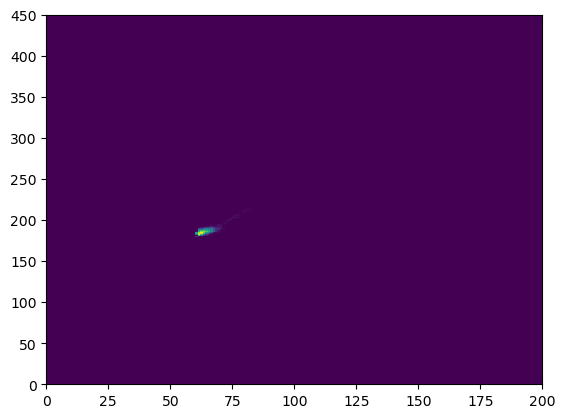

In [59]:
key = '2'
plt.pcolormesh(poly_maps[key]/total_maps[key])


In [ ]:
cdate.split('-')[0]

In [391]:
cdate.split('-')[0]

'2002'

In [381]:
ds2 = xr.open_dataset('../data/polynya_size/daily_polynya_2003_sic10_v7.4_radius25km.nc')


cdate = across[key]['date'][0]

xval = np.array([float(val) for val in ds2.poly_interior_xx.sel(time=cdate).item().split('_')[1:]])
yval = np.array([float(val) for val in ds2.poly_interior_yy.sel(time=cdate).item().split('_')[1:]])

In [382]:
pol_counts = np.zeros_like(dsic['xx'])

for xv, yv in zip(xval, yval):
    
    dist = (dsic['xx']-xv)**2+(dsic['yy']-yv)**2
    
    pol_counts[np.where(dist == 0)] = 1

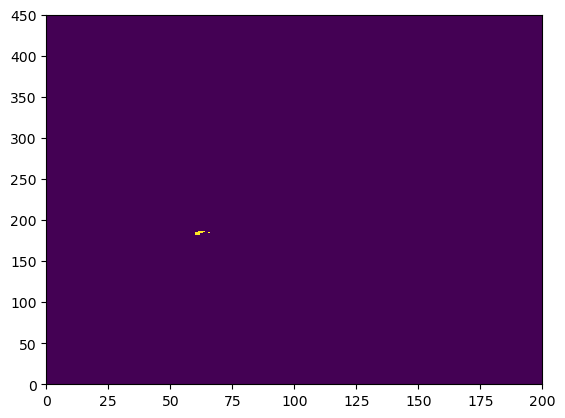

In [383]:
plt.pcolormesh(pol_counts)

In [289]:
key

'1'

In [292]:
np.array(list(across.keys()))

array(['$t_{i}$\n-2', '$t_{i}$\n-1', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10+', '$t_{f}$\n+1', '$t_{f}$\n+2'], dtype='<U10')

In [ ]:


def plot_angles(ax, X, cond, clip):
    label_nums(ax, X, np.sum(cond), clip)
    plot_dist(ax, X-0.15, *angle_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,361,7.5), yscale=1)
    plot_dist(ax, X+0.15, *angle_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,361,7.5), yscale=1)
    
#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
        
def plot_temps(ax, X, cond, clip):
    plot_dist(ax, X, *temp_distribution(df_base, cond), clip, bins = np.arange(-40,0,2), yscale=1)

def plot_msls(ax, X, cond, clip):
    plot_dist(ax, X, *msl_distribution(df_base, cond), clip, bins = np.arange(980,1060,4), yscale=1)
    
def plot_speeds(ax, X, cond, clip):
    plot_dist(ax, X-0.15, *speed_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,20,1), yscale=1)
    plot_dist(ax, X+0.15, *speed_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,40,2), yscale=0.5)    

#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
    
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1, scale = 5, show_mode = False):
    
    h = plotter.quick_hist(y, bin_edges=bins)
    
    if show_mode == True:
        ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
    else:
        ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
        
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   
    
#     ax.barh(h['centers'], scale*h['prob'], height=h['w'], left= X - scale*h['prob']/2, align='center', 
#             color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)
    

def plot_point(ax, X, y, Y, color, bg_color):
    ax.scatter(X, Y, c=color, clip_on=False)
    ax.scatter(np.linspace(X-0.05,X+0.05, len(y)), y, c=bg_color, s=1, zorder=-1, clip_on=False)

    
def size_distribution(df, cond):

    all_sizes = df['extent'][cond]/1000
    mean_size = np.nanmean(all_sizes)
    print(mean_size)
    color = 'k'
    bg_color = 'gray'

    return all_sizes, mean_size, color, bg_color


def msl_distribution(df, cond):

    all_ = df['msl'][cond]/100
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color

def temp_distribution(df, cond):

    all_ = df['t2m'][cond]
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color


def speed_distribution(df, cond, group):
    
    if group == 'atm':
        all_speeds = df['s10'][cond]
        mean_speed = np.nanmean(all_speeds)
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        all_speeds = df['si'][cond] #* units('cm/s').to('km/day').magnitude
        mean_speed = np.nanmean(all_speeds)
        color = 'r'
        bg_color = 'lightcoral'

    return all_speeds, mean_speed, color, bg_color

def angle_distribution(df, cond, group):

    if group == 'atm':
        U = df['u10'][cond]
        V = df['v10'][cond]
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        U = df['ui'][cond]
        V = df['vi'][cond]
        color = 'r'
        bg_color = 'lightcoral'

    all_angles = np.array([vectors.vector_angle(u,v).magnitude for u,v in zip(U,V)])
    mean_angle = vectors.vector_angle(np.nanmean(U), np.nanmean(V)).magnitude
    
    if mean_angle < 0:
        mean_angle+=360
    all_angles[all_angles<0] += 360

    return all_angles, mean_angle, color, bg_color

def label_nums(ax, x, N, clip):
    ax.text(x, -10, N, ha='center',va='bottom', size=5, clip_on=clip)
    
    